In [59]:
import pandas as pd
import joblib
from google.colab import files

df = pd.read_csv('clean_dataset_Romania.csv')

# Notațiile acordate de utilizator pentru fiecare categorie
user_ratings = {
    'nota_personal': 6,
    'nota_facilităţi': 4,
    'nota_curăţenie': 10,
    'nota_confort': 10,
    'nota_raport_calitate/preţ': 10,
    'nota_locaţie': 3,
    'nota_wifi_gratuit': 1
}

# Verificăm dacă suma notelor acordate de utilizator nu depășește numărul maxim de puncte
if sum(user_ratings.values()) > 44:
    print('Suma notelor acordate de utilizator depășește numărul maxim de puncte.')
else:
    # Calculăm scorul de preferință pentru fiecare hotel
    for index, row in df.iterrows():
        preference_score = 0
        for category, user_rating in user_ratings.items():
            preference_score += row[category] * user_rating
        df.loc[index, 'preference_score'] = preference_score

# Lista dvs. de cazări preferate
preferred_accommodations = ['Cabana Sebes Bera', 'Casa de Vacanță S&B', 'Apartament doua camere Retro view']


In [60]:
from sklearn.cluster import KMeans

# Creăm un model KMeans cu un număr specific de clustere
kmeans = KMeans(n_clusters=5, n_init='auto')

# Antrenăm modelul cu datele noastre
kmeans.fit(df[['price', 'nota_personal', 'nota_facilităţi', 'nota_curăţenie', 'nota_confort', 'nota_raport_calitate/preţ', 'nota_locaţie', 'nota_wifi_gratuit']])

# Adăugăm etichetele de cluster la DataFrame
df['cluster'] = kmeans.labels_

# Salvăm datele înainte de filtrare
df_all_clusters = df.copy()

# Identificăm clusterul preferat
preferred_cluster = df[df['name'].isin(preferred_accommodations)]['cluster'].mode()[0]

# Filtrăm DataFrame-ul pentru a include doar hotelurile din clusterul preferat
df = df[df['cluster'] == preferred_cluster]


In [61]:
# Aplicăm filtrele
max_budget = 200
df = df[df['price'] <= max_budget]

preferred_region = 'Braşov'
df = df[df['region'] == preferred_region]

# Identificăm facilitățile care sunt disponibile la cazări preferate
preferred_facilities = df[df['name'].isin(preferred_accommodations)].iloc[:, -37:].sum(axis=0)

# Calculăm scorul de potrivire a facilităților pentru fiecare hotel
for index, row in df.iterrows():
    matching_facilities_score = sum(row[-37:] * preferred_facilities)
    df.loc[index, 'preference_score'] += matching_facilities_score

# Afișăm primele 5 hoteluri cu cel mai mare scor de preferință
print(df.nlargest(5, 'preference_score'))


                                  name  \
339  Apartament doua camere Retro view   
739                              Tudor   
343                         Studio ANA   
713             SECRET boutique Hostel   
783                VivamusApartmentsBV   

                                               address  postal_code  country  \
339                    Strada Negoiu, Făgăraş, România          NaN  România   
739           George Călinescu, 500170 Brașov, România     500170.0  România   
343  Strada Tăbăcari, BL 14, AP 11, 505200 Făgăraş,...     505200.0  România   
713      Strada Alecu Russo 2C, 500020 Brașov, România     500020.0  România   
783       2 Strada Orizontului, 507190 Brașov, România     507190.0  România   

     region   latitude  longitude              check_in             check_out  \
339  Braşov  45.833955  24.974558  De la 14:00 la 20:00  Disponibil 24 de ore   
739  Braşov  45.677021  25.610055  De la 15:00 la 23:30  De la 07:00 la 11:00   
343  Braşov  45.841242 

count        43.000000
mean     171998.332558
std        9070.905190
min      151426.300000
25%      165283.450000
50%      172847.000000
75%      178794.800000
max      185347.000000
Name: preference_score, dtype: float64


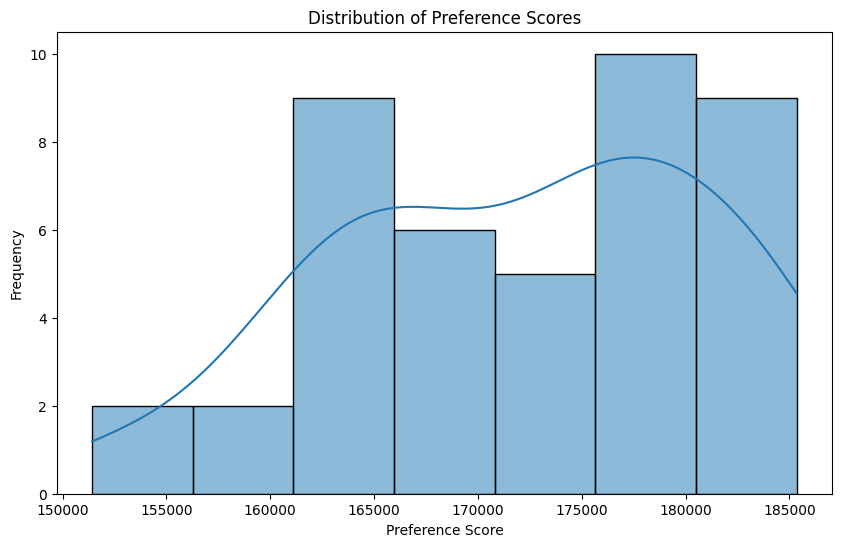

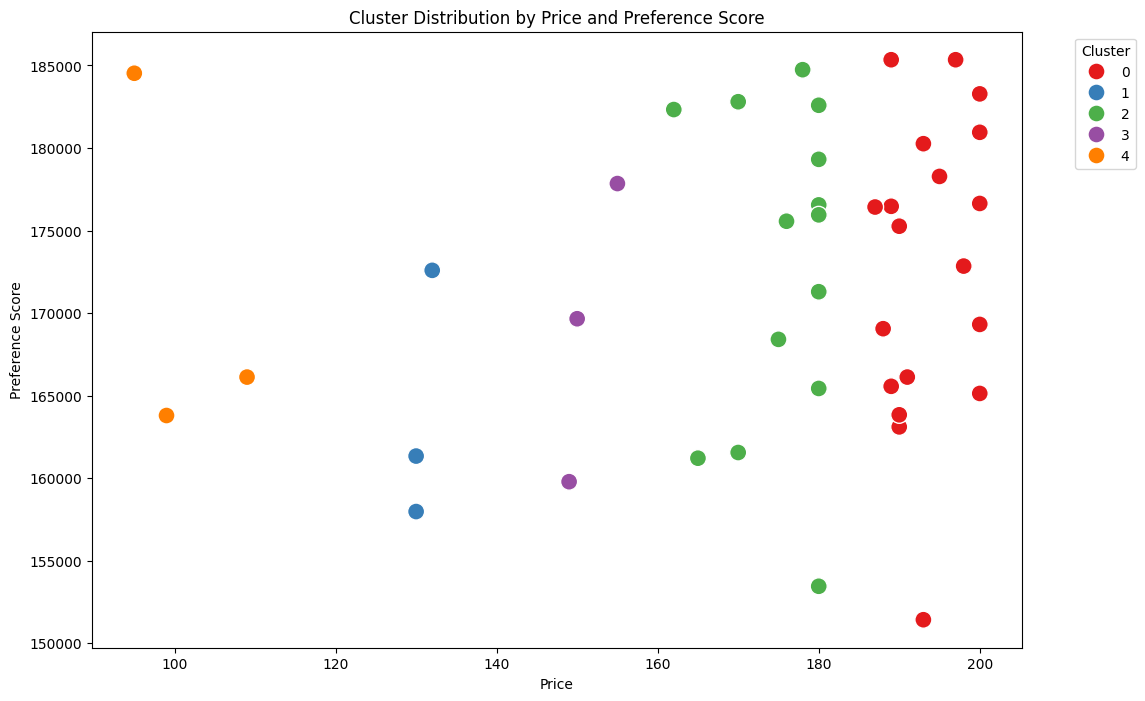

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verificarea valorilor scorurilor de preferință
print(df_all_clusters['preference_score'].describe())

# Distribuția scorurilor de preferință
plt.figure(figsize=(10, 6))
sns.histplot(df_all_clusters['preference_score'], kde=True)
plt.title('Distribution of Preference Scores')
plt.xlabel('Preference Score')
plt.ylabel('Frequency')
plt.show()

# Scatter plot pentru clustere cu preț și scor de preferință
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_all_clusters, x='price', y='preference_score', hue='cluster', palette='Set1', s=150, legend='full')
plt.title('Cluster Distribution by Price and Preference Score')
plt.xlabel('Price')
plt.ylabel('Preference Score')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

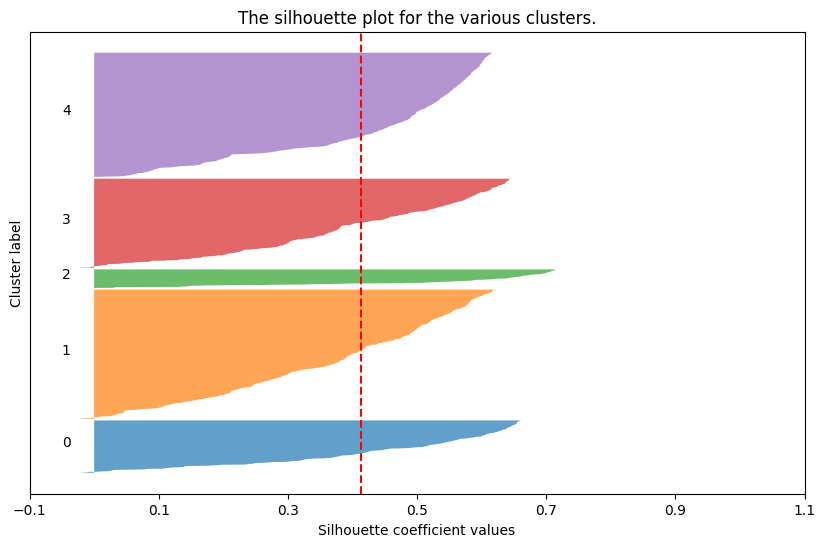

In [62]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Plot pentru scorurile siluetei
y_lower = 10
plt.figure(figsize=(10, 6))

for i in range(len(df_all_clusters['cluster'].unique())):
    ith_cluster_silhouette_vals = silhouette_vals[df_all_clusters['cluster'] == i]
    ith_cluster_silhouette_vals.sort()

    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title('The silhouette plot for the various clusters.')
plt.xlabel('Silhouette coefficient values')
plt.ylabel('Cluster label')

plt.yticks([])  # Clear the y-axis labels / ticks
plt.xticks(np.arange(-0.1, 1.1, 0.2))
plt.show()


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Încărcarea dataset-ului
df = pd.read_csv('clean_dataset_Romania.csv')

# Codificarea one-hot
df = pd.get_dummies(df, columns=['type', 'region', 'room_type'])

# Creează o listă cu numele coloanelor codificate cu one-hot
one_hot_columns = [col for col in df.columns if 'type_' in col or 'region_' in col or 'room_type_' in col]

# Selectați caracteristicile pe care doriți să le utilizați (de exemplu, ratingurile)
selected_columns = one_hot_columns + [
    'persons', 'stars', 'nota_personal', 'nota_facilităţi', 'nota_curăţenie',
    'nota_confort', 'nota_raport_calitate/preţ', 'nota_locaţie', 'nota_wifi_gratuit', 'num_reviews',
    'vedere_la_oras', 'menaj_zilnic', 'canale_prin_satelit', 'zona_de_luat_masa_in_aer_liber', 'cada',
    'facilitati_de_calcat', 'izolare_fonica', 'terasa_la_soare', 'pardoseala_de_gresie/marmura', 'papuci_de_casa',
    'uscator_de_rufe', 'animale_de_companie', 'incalzire', 'birou', 'mobilier_exterior', 'alarma_de_fum',
    'vedere_la_gradina', 'cuptor', 'cuptor_cu_microunde', 'zona_de_relaxare', 'canapea', 'intrare_privata',
    'fier_de_calcat', 'masina_de_cafea', 'plita_de_gatit', 'extinctoare', 'cana_fierbator', 'gradina',
    'ustensile_de_bucatarie', 'masina_de_spalat', 'balcon', 'pardoseala_de_lemn_sau_parchet',
    'aparat_pentru_prepararea_de_ceai/cafea', 'zona_de_luat_masa', 'canale_prin_cablu', 'aer_conditionat', 'masa',
    'suport_de_haine', 'cada_sau_dus', 'frigider', 'mic_dejun'
]

# Creați o matrice de caracteristici
X = df[selected_columns].values

# Aplicam SVD
svd = TruncatedSVD(n_components=5)
X_reduced = svd.fit_transform(X)

# Calculam similaritățile între hoteluri
similarities = cosine_similarity(X_reduced)

# Găsim hotelurile cele mai similare cu primul hotel
top5_similar = np.argsort(similarities[0])[-6:-1][::-1]

# Afișam numele hotelurilor cele mai similare
print(df.iloc[top5_similar]['name'])


726     CASA CHITIC - HOTEL & RESTAURANT- Str Nicolae ...
658                                        Safrano Palace
83                                            Hotel Maxim
2133      DoubleTree by Hilton Hotel Sighisoara - Cavaler
1592                                        Hotel Moldova
Name: name, dtype: object
